## Seasonality

Following the [tutorial](https://www.kaggle.com/code/ryanholbrook/seasonality).

#### Setup

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from pathlib import Path
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


class PreProcessor:
    store_sales_data_types = {
        "store_nbr": "category",
        "family": "category",
        "sales": "float32",
    }
    _store_sales_per_day = None
    _avg_store_sales = None

    holiday_events_data_type = {
        "type": "category",
        "locale": "category",
        "locale_name": "category",
        "description": "category",
        "transferred": "bool",
    }
    _holiday_events = None
    file_path = Path("./data/exercise2")

    @classmethod
    def store_sales_per_day(cls):
        if cls._store_sales_per_day is not None:
            return cls._store_sales_per_day

        data = pd.read_csv(
            cls.file_path / "train.csv",
            usecols=["store_nbr", "family", "date", "sales"],
            dtype=cls.store_sales_data_types,
            parse_dates=["date"],
        )
        data["date"] = data.date.dt.to_period("D")
        data = data.set_index(["store_nbr", "family", "date"]).sort_index()
        cls._store_sales_per_day = data
        return cls._store_sales_per_day

    @classmethod
    def avg_store_sales(cls):
        if cls._avg_store_sales is not None:
            return cls._avg_store_sales

        data = cls.store_sales_per_day()
        data = data.groupby("date").mean().squeeze().loc["2017"]
        cls._avg_store_sales = data
        return cls._avg_store_sales

    @classmethod
    def holiday_events(cls):
        if cls._holiday_events is not None:
            return cls._holiday_events

        data = pd.read_csv(
            cls.file_path / "holidays_events.csv",
            dtype=cls.holiday_events_data_type,
            parse_dates=["date"],
            infer_datetime_format=True,
        )
        data = data.set_index("date").to_period("D")
        cls._holiday_events = data
        return cls._holiday_events


class LinRegression:
    @classmethod
    def run(cls, x, y, x_forecast=None):
        model = LinearRegression()
        model.fit(x, y)
        y_pred = pd.Series(model.predict(x), index=x.index)

        if x_forecast is not None:
            y_forecast = pd.Series(model.predict(x_forecast), index=x_forecast.index)
        else:
            y_forecast = None

        r2 = r2_score(y, y_pred)
        f_values, p_values = f_regression(x, y)
        p_value = p_values[0]

        return model, y_pred, y_forecast, r2, p_value

We're looking at average sales per day for the year 2017.

In [72]:
avg_sales = PreProcessor.avg_store_sales()
avg_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

Now lets plot a seasonal plot, where every week is plotted overlaid.

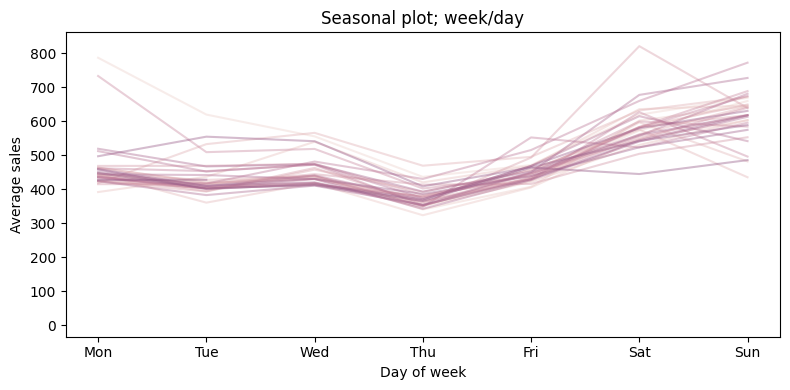

In [73]:
x = avg_sales.to_frame()
x["week"] = x.index.week
x["day"] = x.index.dayofweek

fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(
    data=x.reset_index(),
    x="day",
    y="sales",
    hue="week",
    units="week",
    estimator=None,
    alpha=0.4,
    ax=ax,
    legend=False,
)

ax.set_xticks(range(7))
ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_xlabel("Day of week")
ax.set_ylabel("Average sales")
ax.set_title("Seasonal plot; week/day")

plt.tight_layout()
plt.show()

There is some seasonality in this data. Weekends have higher sales, Thursdays are the worst performing day.

Lets model it using Seasonal Indicators. Once again we generate these features using DeterministicProcess.

We're also using FFT for monthly seasonality. We'd plot a periodogram to confirm the parameters for the fourier transform, here they've been given to us.

In [74]:
y = avg_sales.copy()
fourier = CalendarFourier(freq="M", order=4)

# This is only for regular calendar events.
dp = DeterministicProcess(
    index=x.index,
    constant=True,  # dummy feature for bias (y-intercept)
    order=1,  # trend (order 1 means linear)
    seasonal=True,  # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,  # drop terms to avoid collinearity
)

X = dp.in_sample()
X.head()

/usr/src/app/.venv/lib/python3.14/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


Now let's model y using Linear Regression.

With a little forecast thrown in.

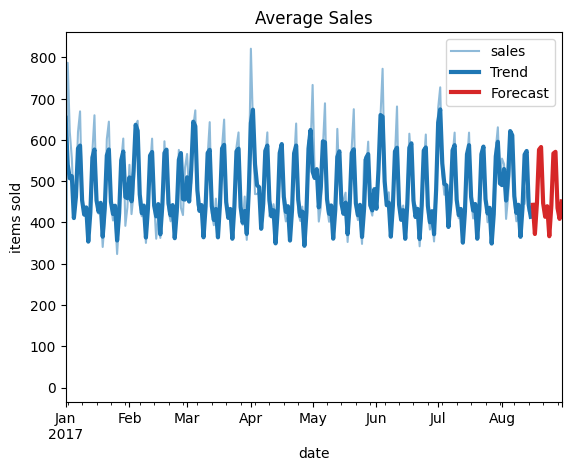

In [75]:
x_forecast = dp.out_of_sample(steps=15)
model, y_pred, y_forecast, r2, p_value = LinRegression.run(X, y, x_forecast)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Forecast", color="C3")
ax.legend()

## Decomposition

We now have a model that fits well-ish. Let's decompose the components to understand what's driving the predictions.

Our data lacks a trend or cycle, so if we remove the seasonal component what do we have left? 

Noise but, also maybe more.

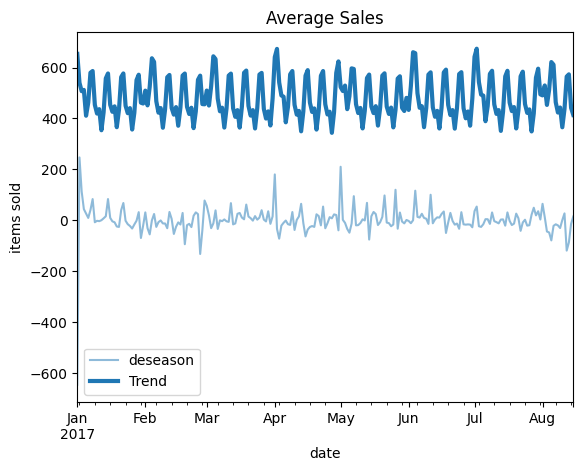

In [76]:
y_deseason = y - y_pred


ax = y_deseason.plot(
    alpha=0.5, label="deseason", title="Average Sales", ylabel="items sold"
)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax.legend()

## Is it just noise left?

The data set we have also contains national and regional holidays. Could they be another season in the time series?

We will plot the deseasoned data we have left, highlighting the holidays.


In [77]:
holidays = PreProcessor.holiday_events()
holidays = (
    holidays.query("locale in ['National', 'Regional']")
    .loc["2017":"2017-08-15", ["description"]]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

holidays.head()

/tmp/ipykernel_21/3750563825.py:63: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(


,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi


/tmp/ipykernel_21/831583283.py:4: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(holidays.index, y_deseason[holidays.index], color="C3")
/tmp/ipykernel_21/831583283.py:4: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  plt.plot_date(holidays.index, y_deseason[holidays.index], color="C3")


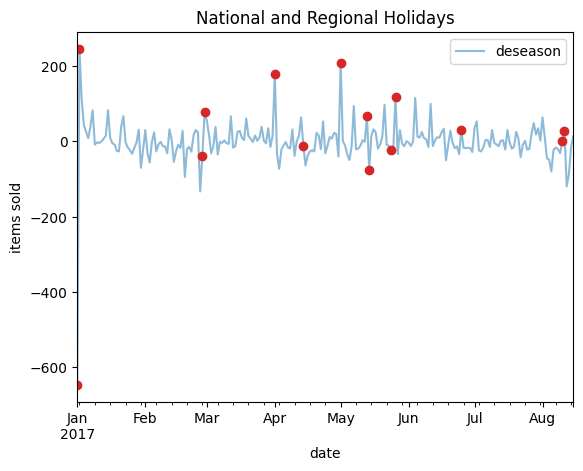

In [78]:
ax = y_deseason.plot(
    alpha=0.5, label="deseason", title="Average Sales", ylabel="items sold"
)
plt.plot_date(holidays.index, y_deseason[holidays.index], color="C3")
ax.set_title("National and Regional Holidays")
ax.legend()

We've got another season in the time series! It's almost like the tutorial told me the answer!

Now we're going to model this with holidays as a categorical variable, using a one-hot encoding approach.

I did try to use `DeterministicProcessor` again but, found out it's only for regular calendar events. For irregular or custom holidays, we need to use one-hot encoding.

In [82]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
Z = ohe.fit_transform(holidays[["description"]])
X_holidays = pd.DataFrame(
    Z,
    index=holidays.index,
    columns=holidays.description.unique(),
)


X_holidays = pd.get_dummies(holidays)
X = X.join(X_holidays, on="date").fillna(0.0)
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,False,False,False,True,False,False,False,False,False,False
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,False,False,False,False,False,False,False,False,True,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we model again using our updated matrix of features and the index of dates.

When we plot this out we can see our line fits even better. Nice.

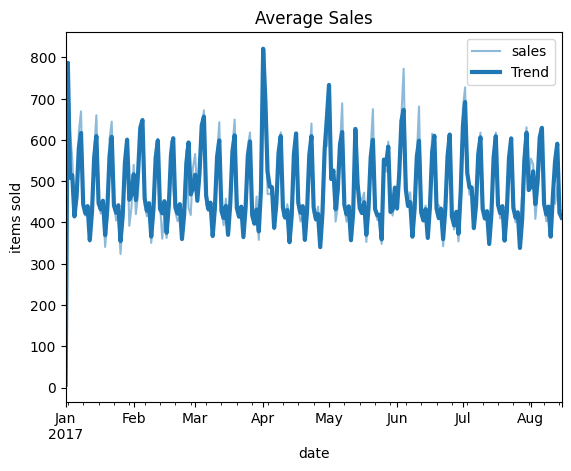

In [83]:
model, y_pred, _, r2, p_value = LinRegression.run(X, y, None)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax.legend()